# Quantum Phase Estimation

In this notebook, we'll look at one of the most useful applications of the Quantum Fourier Transform we saw last week.

Here's the problem in very simple terms: we are given some state $|\psi\rangle$, some unitary operator $U$, such that $U|\psi\rangle = e^{2\pi i \theta} |\psi\rangle$; the goal of phase estimation is to estimate the phase $\theta$.

In the problem, we assume we can implement $U$ and powers of two of $U$ ($U^{2^{j}}$) in a quantum circuit, as well as controlled versions of these.

In the QPE circuit we will implement we have two sets of qubits (we call those _registers_). The first register contains $t$ qubits which will represent (in binary) the phase $\theta$, up to accuracy $2^{-t}$, and the second register will store the actual state $|\psi\rangle$.

Before we move on, let's introduce some quick notation. $|+\rangle= \frac{1}{\sqrt{2}} (|0\rangle+|1\rangle)$, and $|-\rangle= \frac{1}{\sqrt{2}} (|0\rangle-|1\rangle)$. That's it.

The main trick to be identified here is as follow. Let's assume we have one qubit in the first register, and that we start in the state $|+\rangle |\psi\rangle$. Applying a controlled $U^{k}$ on $|\psi\rangle$ with the first qubit as control, we get

$\begin{array}{ll}U^k (|+\rangle |\psi\rangle)&= |0\rangle|\psi\rangle + |1\rangle U^k |\psi\rangle \\
&= |0\rangle|\psi\rangle + |1\rangle U^{k-1} U |\psi\rangle \\
&= |0\rangle|\psi\rangle + |1\rangle U^{k-1} e^{2\pi i \theta}  |\psi\rangle \\
&= |0\rangle|\psi\rangle + |1\rangle e^{2\pi k i \theta}  |\psi\rangle
 \end{array}$

Thus, if we apply $U$ on $|\psi\rangle$ with $q_0$ as control, then $U^2$ with $q_1$, $U^4$ with $q_2$, and so on, we can write out the state of the $t$ qubits of the first register: $\frac{1}{\sqrt{2^{t/2}}}\sum_{k=0}^{2^t-1}e^{2\pi i \theta k}|k\rangle$.

Now comes the most important part: you clearly see that the qubits have the form of a Quantum Fourier transformed register that we introduced last week (and it is clear that the values in the register represent a periodic function). So when we've applied all these phases to our qubits, all we need to do is apply an iQFT to get the bitstring $|\theta_0...\theta_{t-1}\rangle$, which represents the binary expansion notation of the frequency $\theta$, as we described in last week's notebook.  

Alright, time to write this down. Let's have our tradition of installing everything first.

In [16]:
#pip install qiskit[visualization] --quiet

#pip install matplotlib --quiet

Let's write a simple function for the unitary operator $U$ (and all related powers). We'll make a random unitary function so that we can try our QPE algorithm multiple times.

There's an easy trick to create a random unitary: create a random Hamiltonian matrix $H$ with $R + R^{\dagger}$, where $R$ is a random complex matrix. Then, take $e^{iH}$ (it should be obvious why this is unitary). I already wrote a function for that, within a for-loop because we will need all the $U^{2^j}$ powers of the $U$ matrix right away.

A little Python commentary here: in the `random_unitary_iter` I use the `yield` keyword. This creates an _iterable_ from the function. In a sense, it's kind of equivalent to creating a list and adding items to it, except, in the `yield` case, I don't know in advance what the list is like, its length, etc. The main advantage is that I don't need to compute everything first, and I can defer the computations to the for-loop. Since in quantum computing we may go to larger matrices, the list could grow heavy in size. The iterable allows us to avoid potential memory errors.

In [17]:
from typing import Iterable

import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import expm

def random_unitary_iter(r1:int,r2:int)->Iterable:
    rham = np.random.rand(2**r2,2**r2) + 1j*np.random.rand(2**r2,2**r2)
    rham += np.conj(np.transpose(rham))
    irham = 1j*rham
    for m in range(r1):
        rut=expm((2**m)*irham)
        rut/np.trace(rut)
        yield rut

def controlled_U_gate(circ:QuantumCircuit,ctrl:int,targs:list,rut:np.ndarray)->None:
    rut_gate=UnitaryGate(rut)
    crut_gate = rut_gate.control(1)
    circ.append(crut_gate,qargs=[ctrl,*targs])

Alright, now that we have our unitaries, we can build the circuit. The setup is as follows. We apply Hadamards to the first register, then apply controlled $U^{2^j}$ on the second register controlled by $q_j$, and finally, we use an iQFT to get the number back.

This week, there's no exercise, you can just watch the magic happen!

Quick remark on applying gates: in Qiskit, you can apply a gate to an `int` (the index of the qubit), a `list` of `int` (multiple qubits), or a full `QuantumRegister` (also multiple qubits). The advantage of using the last method is that your circuit remember your different registers, and you don't need to remember them yourself. You can access the first register from the circuit by using `circ.qregs[0]` for example. This allows you to keep track of the different groups of qubits defined in the circuit without remembering their specific indices.

In the case of QPE, it's very useful, since we deal with two well-defined registers.


In [18]:
from typing import Tuple

from qiskit import QuantumRegister
from qiskit.result import Counts
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

def plot_counts(counts:Counts):
    plt.plot(
        range(len(counts.int_outcomes().values())),
        np.abs(list(counts.int_outcomes().values())),
        "rs:",
        markerfacecolor='none',
        label="counts"
    )
    plt.legend()
    plt.show()

def get_random_phase_and_psi(unitary:np.ndarray)->np.ndarray:
    eigvals,eigvecs=np.linalg.eig(unitary)
    idx = np.random.randint(0,len(eigvals))

    # eigval = e^{2pi i theta}
    eigval = eigvals[idx]
    phase = np.real(-1j * np.log(eigval)/(2*np.pi))
    phase = np.mod(phase,1)
    psi = eigvecs[:,idx]
    return phase,psi

def qpe_circuit(r1:int,r2:int)->Tuple[QuantumCircuit,float]:

    first_register=QuantumRegister(r1,"first")
    second_register=QuantumRegister(r2,"second")

    circ = QuantumCircuit(first_register,second_register)
    circ.h(first_register)

    unitaries = random_unitary_iter(r1,r2)

    get_phase_and_psi=True
    for ind,unitary in enumerate(unitaries):
        if get_phase_and_psi:
            phase,psi= get_random_phase_and_psi(unitary)
            get_phase_and_psi=False

        controlled_U_gate(circ=circ,ctrl=ind,targs=second_register,rut=unitary)

    circ.append(QFT(num_qubits=len(first_register),inverse=True,do_swaps=True),qargs=first_register)

    return circ,phase,psi

def bitstring_idx_to_phase(index)->float:
    bin(index)

def get_phase_from_qpe_circuit(circ:QuantumCircuit,psi:np.ndarray)->float:

    out_circ = circ.copy_empty_like()

    out_circ.prepare_state(state=psi,qubits=circ.qregs[1])
    out_circ.append(circ,qargs=circ.qubits)
    statevector = Statevector.from_instruction(out_circ)

    r1=len(out_circ.qregs[0])
    counts=statevector.sample_counts(1000,qargs=range(r1))
    bitstring =counts.most_frequent()

    return np.sum([(int(v))*2**-(i+1) for i,v in enumerate(bitstring)])

Ok, let's now test the QPE algorithm to see whether it's able to guess the eigenvalue of some eigenvector given some random $U$. If you get an error of $\sim 0.001$ we should be good.

trial 0 | correct: 0.80684, guess: 0.00000 err: 0.80684
trial 1 | correct: 0.06626, guess: 0.00000 err: 0.06626
trial 2 | correct: 0.74718, guess: 0.50000 err: 0.24718
trial 3 | correct: 0.08552, guess: 0.00000 err: 0.08552
trial 4 | correct: 0.63432, guess: 0.50000 err: 0.13432
trial 5 | correct: 0.06024, guess: 0.00000 err: 0.06024
trial 6 | correct: 0.91682, guess: 0.00000 err: 0.91682
trial 7 | correct: 0.51922, guess: 0.50000 err: 0.01922
trial 8 | correct: 0.85326, guess: 0.00000 err: 0.85326
trial 9 | correct: 0.96865, guess: 0.00000 err: 0.96865


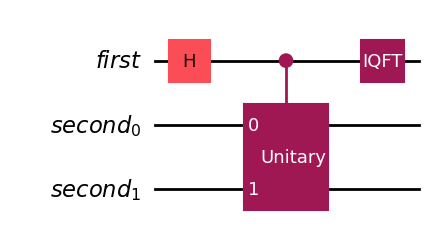

In [29]:
for trial in range(10):
    circ,phase,psi = qpe_circuit(1,2)
    computed_phase = get_phase_from_qpe_circuit(circ,psi)
    print(f"trial {trial} | correct: {phase:.5f}, guess: {computed_phase:.5f} err: {np.abs(phase-computed_phase):.5f}")
circ.draw(output="mpl")